<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 10
blockSize = 32
testBlockSize = 400
numVars = 1
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation, lossFunc, relativeErr
import random
import json

files = glob.glob("/content/drive/MyDrive/Colab Notebooks/STAT946_proj/data/1_var_train.json")
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498795 examples, 27 unique.
id:447738
outputs:C*log(C*x1)+C>_____________________
variables:1


In [22]:
files = glob.glob("/content/drive/MyDrive/Colab Notebooks/STAT946_proj/data/1_var_test.json")
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 967 examples, 27 unique.
tensor(-7.8646) tensor(2.9267)
id:34
outputs:C*log(C*x1)+C>_____________________
variables:1


In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
from utils import get_predicted_skeleton


# from SymbolicGPT: https://github.com/mojivalipour/symbolicgpt/blob/master/models.py
class PointNetConfig:
    """base PointNet config"""

    def __init__(
        self,
        embeddingSize,
        numberofPoints,
        numberofVars,
        numberofYs,
        method="GPT",
        varibleEmbedding="NOT_VAR",
        **kwargs,
    ):
        self.embeddingSize = embeddingSize
        self.numberofPoints = numberofPoints  # number of points
        self.numberofVars = numberofVars  # input dimension (Xs)
        self.numberofYs = numberofYs  # output dimension (Ys)
        self.method = method
        self.varibleEmbedding = varibleEmbedding

        for k, v in kwargs.items():
            setattr(self, k, v)


class tNet(nn.Module):
    """
    The PointNet structure in the orginal PointNet paper:
    PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation by Qi et. al. 2017
    """

    def __init__(self, config):
        super(tNet, self).__init__()

        self.activation_func = F.relu
        self.num_units = config.embeddingSize

        self.conv1 = nn.Conv1d(
            config.numberofVars + config.numberofYs, self.num_units, 1
        )
        self.conv2 = nn.Conv1d(self.num_units, 2 * self.num_units, 1)
        self.conv3 = nn.Conv1d(2 * self.num_units, 4 * self.num_units, 1)
        self.fc1 = nn.Linear(4 * self.num_units, 2 * self.num_units)
        self.fc2 = nn.Linear(2 * self.num_units, self.num_units)

        # self.relu = nn.ReLU()

        self.input_batch_norm = nn.BatchNorm1d(config.numberofVars + config.numberofYs)
        # self.input_layer_norm = nn.LayerNorm(config.numberofPoints)

        self.bn1 = nn.BatchNorm1d(self.num_units)
        self.bn2 = nn.BatchNorm1d(2 * self.num_units)
        self.bn3 = nn.BatchNorm1d(4 * self.num_units)
        self.bn4 = nn.BatchNorm1d(2 * self.num_units)
        self.bn5 = nn.BatchNorm1d(self.num_units)

    def forward(self, x):
        """
        :param x: [batch, #features, #points]
        :return:
            logit: [batch, embedding_size]
        """
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4 * self.num_units

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))
        # x = self.fc2(x)

        return x


class NoisePredictionTransformer(nn.Module):
    def __init__(self, n_embd, max_seq_len, n_layer=6, n_head=8, max_timesteps=1000):
        super().__init__()
        self.pos_emb = nn.Parameter(torch.zeros(1, max_seq_len, n_embd))
        self.time_emb = nn.Embedding(max_timesteps, n_embd)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_embd,
            nhead=n_head,
            dim_feedforward=n_embd * 4,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layer)

    def forward(self, x_t, t, condition):
        _, L, _ = x_t.shape
        pos_emb = self.pos_emb[:, :L, :]  # [1, L, n_embd]
        time_emb = self.time_emb(t)
        if time_emb.dim() == 1:  # Scalar t case, [n_embd]
            time_emb = time_emb.unsqueeze(0)  # [1, n_embd]
        time_emb = time_emb.unsqueeze(1)  # [1, 1, n_embd]
        condition = condition.unsqueeze(1)  # [B, 1, n_embd]

        x = x_t + pos_emb + time_emb + condition
        return self.encoder(x)


# influenced by https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/simple_diffusion.py
class SymbolicGaussianDiffusion(nn.Module):
    def __init__(
        self,
        tnet_config,
        vocab_size,
        max_seq_len,
        padding_idx: int = 0,
        max_num_vars: int = 9,
        n_layer=6,
        n_head=8,
        n_embd=512,
        timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        ce_weight=1.0,  # Weight for CE loss relative to MSE
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.padding_idx = padding_idx
        self.n_embd = n_embd
        self.timesteps = timesteps
        self.ce_weight = ce_weight

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.tok_emb = nn.Embedding(vocab_size, n_embd, padding_idx=self.padding_idx)
        self.vars_emb = nn.Embedding(max_num_vars, n_embd)

        self.decoder = nn.Linear(n_embd, vocab_size, bias=False)
        self.decoder.weight = self.tok_emb.weight

        self.tnet = tNet(tnet_config)
        self.model = NoisePredictionTransformer(
            n_embd, max_seq_len, n_layer, n_head, timesteps
        )

        # Noise schedule
        self.register_buffer("beta", torch.linspace(beta_start, beta_end, timesteps))
        self.register_buffer("alpha", 1.0 - self.beta)
        self.register_buffer("alpha_bar", torch.cumprod(self.alpha, dim=0))

    def q_sample(self, x_start, t, noise=None):
        noise = torch.randn_like(x_start)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t]).view(-1, 1, 1)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1)

        x_t = sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise
        return x_t

    def p_mean_variance(self, x, t, t_next, condition):
        alpha_t = self.alpha[t]
        alpha_bar_t = self.alpha_bar[t]
        alpha_bar_t_next = self.alpha_bar[t_next]
        beta_t = self.beta[t]

        x_start_pred = self.model(x, t.long(), condition)

        coeff1 = torch.sqrt(alpha_bar_t_next) * beta_t / (1 - alpha_bar_t)
        coeff2 = torch.sqrt(alpha_t) * (1 - alpha_bar_t_next) / (1 - alpha_bar_t)
        mean = coeff1 * x_start_pred + coeff2 * x
        variance = (1 - alpha_bar_t_next) / (1 - alpha_bar_t) * beta_t
        return mean, variance

    @torch.no_grad()
    def p_sample(self, x, t, t_next, condition):
        mean, variance = self.p_mean_variance(x, t, t_next, condition)
        if torch.all(t_next == 0):
            return mean
        noise = torch.randn_like(x)
        return mean + torch.sqrt(variance) * noise

    @torch.no_grad()
    def sample(self, points, variables, train_dataset, batch_size=16):
        condition = self.tnet(points) + self.vars_emb(variables)
        shape = (batch_size, self.max_seq_len, self.n_embd)
        x = torch.randn(shape, device=self.device)
        steps = torch.arange(self.timesteps - 1, -1, -1, device=self.device)

        for i in tqdm(
            range(0, self.timesteps, 20), desc="sampling loop", total=self.timesteps
        ):
            t = steps[i]
            t_next = (
                steps[i + 20]
                if i + 20 < self.timesteps
                else torch.tensor(0, device=self.device)
            )
            x = self.p_sample(x, t, t_next, condition)

            # Print prediction every 250 steps
            #if (i + 1) % 250 == 0:
            #    logits = self.decoder(x)  # [B, L, vocab_size]
            #    token_indices = torch.argmax(logits, dim=-1)  # [B, L]
            #    for j in range(batch_size):
            #       token_indices_j = token_indices[j]  # [L]
            #        predicted_skeleton = get_predicted_skeleton(
            #            token_indices_j, train_dataset
            #        )
            #        tqdm.write(f" sample {j}: predicted_skeleton: {predicted_skeleton}")

        logits = self.decoder(x)  # [B, L, vocab_size]
        token_indices = torch.argmax(logits, dim=-1)  # [B, L]
        predicted_skeletons = []
        for j in range(batch_size):
            token_indices_j = token_indices[j]  # [L]
            predicted_skeleton = get_predicted_skeleton(token_indices_j, train_dataset)
            predicted_skeletons.append(predicted_skeleton)
        return predicted_skeletons

    def p_losses(
        self, x_start, points, tokens, variables, t, noise=None, mse: bool = False
    ):
        """Hybrid loss: MSE on embeddings + CE on tokens."""
        noise = torch.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise)
        condition = self.tnet(points) + self.vars_emb(variables)
        x_start_pred = self.model(x_t, t.long(), condition)

        # MSE loss on embeddings
        if mse:
            mse_loss = F.mse_loss(x_start_pred, x_start)
        else:
            mse_loss = torch.tensor(0.0, device=self.device)

        # CE loss on tokens
        logits = self.decoder(x_start_pred)  # [B, L, vocab_size]
        ce_loss = F.cross_entropy(
            logits.view(-1, self.vocab_size),  # [B*L, vocab_size]
            tokens.view(-1),  # [B*L]
            ignore_index=self.padding_idx,
            reduction="mean",
        )

        total_loss = mse_loss + self.ce_weight * ce_loss
        return total_loss, mse_loss, ce_loss

    def forward(self, points, tokens, variables, t, mse=False):
        token_emb = self.tok_emb(tokens)
        total_loss, mse_loss, ce_loss = self.p_losses(
            token_emb, points, tokens, variables, t, mse=mse
        )
        return total_loss, mse_loss, ce_loss


In [23]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            # Fit constants
            c = [1.0 for _ in range(predicted.count("C"))]
            if c:
                try:
                    cHat = minimize(lossFunc, c, args=(predicted, t["X"], t["Y"]))
                    if cHat.success and cHat.fun != float(
                        "inf"
                    ):  # Check if optimization succeeded and equation is valid
                        predicted = predicted.replace("C", "{}").format(*cHat.x)
                    else:
                        print(
                            f"Skipping sample {batch_idx * B + i + 1}: Invalid predicted equation or optimization failed\n"
                        )
                        continue
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: Error fitting constants: {e}\n"
                    )
                    continue

            # Evaluate both equations
            Ys = []
            Yhats = []
            valid_sample = True
            for xs in t["XT"]:
                # Target evaluation
                try:
                    eqTmp = eq.replace(" ", "").replace("\n", "")
                    for j, x in enumerate(xs):
                        eqTmp = eqTmp.replace("x{}".format(j + 1), f"({x})")
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    Ys.append(YEval)
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: TA: Invalid target equation. Eq: {eqTmp}, Reason: {e}\n"
                    )
                    valid_sample = False
                    break

                # Predicted evaluation
                try:
                    eqTmp = predicted.replace(" ", "").replace("\n", "")
                    for j, x in enumerate(xs):
                        eqTmp = eqTmp.replace("x{}".format(j + 1), f"({x})")
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhats.append(Yhat)
                except Exception as e:
                    print(
                        f"Skipping sample {batch_idx * B + i + 1}: PR: Invalid predicted equation. Eq: {eqTmp}, Reason: {e}\n"
                    )
                    valid_sample = False
                    break

            if not valid_sample:
                continue

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(predicted)
            results["error"].append(err)

            #print(f"\nSample {batch_idx * B + i + 1}:")
            #print(f"Target: {eq}")
            #print(f"Target Skeleton: {eq_skeleton}")
            #print(f"Predicted Skeleton: {predicted_skeleton}")
            #print(f"Predicted: {predicted}")
            #print(f"Relative Error: {err:.6f}")
            #print("-" * 50)

    return results


In [26]:
import numpy as np
from matplotlib import pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='SymbolicGPT'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    fName = 'results_symbolic_diffusion_116.txt'
    modelKey = 'SymbolicDiffusion'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()

{0: '(', 1: ')', 2: '*', 3: '**', 4: '+', 5: '/', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: ':', 17: '<', 18: '>', 19: 'C', 20: 'T', 21: '_', 22: 'cos', 23: 'exp', 24: 'log', 25: 'sin', 26: 'x1'}


sampling loop:   5%|▌         | 50/1000 [00:07<02:22,  6.68it/s]


yPR,yTrue:-1.1886541697078452,-1.1886541155058157, Err:4.512514650690379e-16
yPR,yTrue:-1.1886541689705594,-1.1886541155058155, Err:4.3905862272972776e-16
yPR,yTrue:-1.1886541573885152,-1.1886541155058157, Err:2.6943676797976907e-16
yPR,yTrue:-1.188654162091727,-1.1886541155058155, Err:3.3334713274893364e-16
yPR,yTrue:-1.188654101109448,-1.1886541155058152, Err:3.1834157408315234e-17
yPR,yTrue:-0.251375991838142,-281.19907406546463, Err:10.428399089680541
yPR,yTrue:-0.2500790917535126,-1803.329537151023, Err:429.5328841510047
yPR,yTrue:-0.24724410336513314,375.5984025087149, Err:18.66318389388495
yPR,yTrue:18.640379037655137,0.7276226658398632, Err:0.042392743680692194
yPR,yTrue:4.061871134320956,0.7238762878943856, Err:0.0014721023654452987
Skipping sample 3: TA: Invalid target equation. Eq: 0.5035538309121157*(-3.07921534)**5+-1.7880275308333555*(-3.07921534)**4+1.9763031036747143*(-3.07921534)**3+0.64126273976877*(-3.07921534)**2*1.9018843748420244*log(0.8634365809569955*(-3.0792153

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 223: TA: Invalid target equation. Eq: -0.5202508430762638*exp(-0.1372544176912407*(3.92243578))/-1.3219760079498015*log(-1.0511398449064597*(3.92243578))+-1.8379334612927076, Reason: math domain error

Skipping sample 224: TA: Invalid target equation. Eq: 0.5318928808388534*(3.24341583)**4+1.2369971764000574*exp(1.5465049651271112*(3.24341583))*0.18492489787681476*log(-0.15347929536815652*(3.24341583))+0.3317799766310161, Reason: math domain error

Skipping sample 225: PR: Invalid predicted equation. Eq: 1.0*sin(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:5.42198784254457,4.685384780375525, Err:0.01123042393601769
yPR,yTrue:6.2066806101646,5.312173800119844, Err:0.016561375851665776
yPR,yTrue:-6.892432655651205,-9.864705550603436, Err:0.18285484534063873
yPR,yTrue:4.943111801257525,4.300049882459428, Err:0.008559229964404419
yPR,yTrue:-8.723037673430166,-15.513016941706923, Err:0.9542584345936926
yPR,yTrue:-1.7709391094574822,-1.7709390131285587, Err

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 250: TA: Invalid target equation. Eq: -0.6783007564314896*(-3.84547711)**4+-0.1921775544583335*(-3.84547711)**3+-0.17197917786237293*(-3.84547711)**2+1.632149632515198*(-3.84547711)+-1.1359640960684754*log(1.7886063322921824*(-3.84547711))*1.5621799710566084*cos(0.037523932632632206*(-3.84547711))/-1.918042223003552*cos(1.8524347448010956*(-3.84547711))+-1.8516666936519734, Reason: math domain error

Skipping sample 251: PR: Invalid predicted equation. Eq: 1.0*(-3.61937317)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:38.46017040349551,38.460170535013305, Err:9.591240019366285e-17
yPR,yTrue:46.2447303968122,46.24473055327814, Err:1.357517194279646e-16
yPR,yTrue:37.78537797241974,37.785378101774945, Err:9.27841004332978e-17
yPR,yTrue:26.219622011285402,26.219622103574395, Err:4.7228650612136904e-17
yPR,yTrue:25.40755214508485,25.407552234771305, Err:4.4602525495717797e-17
Skipping sample 253: PR: Invalid predicted equation. Eq: 1.0*(-3.88791007)(1.0*(-

sampling loop:   5%|▌         | 50/1000 [00:07<02:14,  7.05it/s]


yPR,yTrue:-0.8136641317902025,-0.8152827440796399, Err:5.890665110383152e-07
yPR,yTrue:-0.8137754396708778,-0.8155283707942335, Err:6.908891469163571e-07
yPR,yTrue:-0.8060230378291502,-0.8067366088064951, Err:1.1448616880841801e-07
yPR,yTrue:-0.8043438663237404,-0.806061267530967, Err:6.631659113625404e-07
yPR,yTrue:-0.8149148831095558,-0.8183835737842223, Err:2.7052649886331794e-06
Skipping sample 258: TA: Invalid target equation. Eq: 0.5489857163403724*log(0.6268040365231822*(-4.67051946))+-2.043103910965079, Reason: math domain error

Skipping sample 259: PR: Invalid predicted equation. Eq: 1.0*(4.73957131)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 260: TA: Invalid target equation. Eq: -0.6894762711194902*(4.16277098)**2+-1.266029662627414*log(-0.26586121798004103*(4.16277098))+0.10266145852190789, Reason: math domain error

yPR,yTrue:-1803.1115174795611,-1803.111519212338, Err:8.321297775794504e-17
yPR,yTrue:-1716.919206405794,-1716.9192080554308, Err:7.

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Skipping sample 266: PR: Invalid predicted equation. Eq: 1.0*(-3.20307739)(1.0*(-3.20307739))+1.0, Reason: 'float' object is not callable

yPR,yTrue:2.397153078623169,2.4625922726185503, Err:0.000201288771793293
yPR,yTrue:1.6174261476400527,1.6595689314551425, Err:8.348147376621376e-05
yPR,yTrue:2.2290833256149933,2.2896505775983083, Err:0.00017243261163550996
yPR,yTrue:-4.836649871987062,-4.65932296573728, Err:0.0014780629851192007
yPR,yTrue:-4.618306657671058,-4.463739934477264, Err:0.0011229894255667806
Skipping sample 268: PR: Invalid predicted equation. Eq: 1.0*log(1.0*(-4.6079034))+1.0, Reason: math domain error

yPR,yTrue:1.142205852666107,1.142205864274113, Err:1.8575967531190574e-17
yPR,yTrue:1.1037452425121972,1.1037452537777037, Err:1.7495954242367077e-17
yPR,yTrue:1.077862398782651,1.0778624098176655, Err:1.678734439345318e-17
yPR,yTrue:1.0561386398364148,1.0561386506779744, Err:1.620390597081139e-17
yPR,yTrue:1.068553464863974,1.0685534758160906, Err:1.6536069940304866e-17

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

yPR,yTrue:-0.1101268827495394,1.1851215275989795, Err:0.21788949936482485
yPR,yTrue:0.07849919290667846,1.1861544873169325, Err:0.15934535955953294
yPR,yTrue:0.11723171802935989,0.8405501001826343, Err:0.0679499543967748
yPR,yTrue:0.11723171802935989,0.8405501001826343, Err:0.0679499543967748
yPR,yTrue:0.009358277336547939,-1.072516054990884, Err:0.1520140744162447
yPR,yTrue:-0.11593259514494025,-0.11593262159965445, Err:1.6989129718170135e-16
yPR,yTrue:-0.026146418355534662,-0.02614645240295277, Err:2.8140599952367583e-16
yPR,yTrue:-0.07378798349422422,-0.07378801351286746, Err:2.1874951719606027e-16
yPR,yTrue:-1.063040020201775,-1.0630399665650263, Err:6.983769087974941e-16
yPR,yTrue:-0.026146418355534662,-0.02614645240295277, Err:2.8140599952367583e-16
yPR,yTrue:-0.2836976606673422,-2.408881884151028, Err:0.46905636815715673
yPR,yTrue:-0.27904315423547277,-2.2643663507819918, Err:0.40934953740749014
yPR,yTrue:-2.6092495063795678,-1.123750172083444, Err:0.229180041188338
yPR,yTrue:-0

sampling loop:   5%|▌         | 50/1000 [00:07<02:18,  6.88it/s]


yPR,yTrue:-4.106803266063226,11.618201399373678, Err:5.105744866217988
yPR,yTrue:-3.3762152525333984,7.993955300457779, Err:2.6693867580503534
yPR,yTrue:-4.106803266063226,11.618201399373678, Err:5.105744866217988
yPR,yTrue:-3.277984216324312,7.560631186065874, Err:2.425633352229632
yPR,yTrue:-4.00939628794501,11.09410508651155, Err:4.710129223604598
Skipping sample 514: TA: Invalid target equation. Eq: -0.49122815416635524*sin(-0.7699440900223671*log(1.38548389024339*(-4.59408016)+-1.5293409374507783))+-1.4305087201815025, Reason: math domain error

Skipping sample 515: PR: Invalid predicted equation. Eq: 1.0*(3.68791148)(1.0, Reason: '(' was never closed (<string>, line 1)

Skipping sample 516: PR: Invalid predicted equation. Eq: 1.0*(-4.40366335)(1.0, Reason: '(' was never closed (<string>, line 1)

yPR,yTrue:4.52517677964975,6.68188665735495, Err:0.11343649731337875
yPR,yTrue:-4.454916769465945,-6.255324445506561, Err:0.07905167288958818
yPR,yTrue:6.199774004571901,9.28536788421251

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

yPR,yTrue:-0.16362499039068035,-0.38054119886621063, Err:0.029262356240646395
yPR,yTrue:0.23472551280696363,0.10792097596501171, Err:0.009999881830513958
yPR,yTrue:-0.19357138731240986,-0.4072896823824794, Err:0.02840590862045187
yPR,yTrue:-0.18674794537149486,-0.40128464823179943, Err:0.02862387899901519
yPR,yTrue:-0.2077628967862779,-0.41961411880052746, Err:0.027911760545502675
yPR,yTrue:211.83570663887681,211.83570815558818, Err:9.773834485753023e-16
yPR,yTrue:199.42799314745284,199.42799457873195, Err:8.703777247084126e-16
yPR,yTrue:213.5710407270154,213.57104225567528, Err:9.928435833851853e-16
yPR,yTrue:154.6544388554089,154.65443997840345, Err:5.358144152287624e-16
yPR,yTrue:337.54414837990913,337.5441507621755, Err:2.411236085149095e-15
yPR,yTrue:88.50691383251137,-49.08508401346863, Err:55.70367118959561
yPR,yTrue:101.04106287265073,-63.16624460716655, Err:79.33821499718502
yPR,yTrue:97.69751970039287,-59.283015850559664, Err:72.50852623082812
yPR,yTrue:91.91068201203777,137.

sampling loop:   5%|▌         | 50/1000 [00:05<01:46,  8.94it/s]


yPR,yTrue:-1.716910849435713,-1.6103149662190854, Err:0.0013354515521555466
yPR,yTrue:-1.7189453887386057,-1.6103187247251594, Err:0.0013868201945013915
yPR,yTrue:-1.7256180901025286,-1.6103295186601208, Err:0.0015621394067528154
yPR,yTrue:-1.7039129127323402,-1.6102844852493652, Err:0.001030297702013203
yPR,yTrue:-1.4212914490244553,-1.0430537031389815, Err:0.01681423085459187
yPR,yTrue:0.4638029722498104,0.07949487582983661, Err:0.01708079467816827
yPR,yTrue:0.40327802372206234,1.6818402723651071, Err:0.1890569983529438
yPR,yTrue:0.3339968772083865,0.9221116066401124, Err:0.040001208948244577
yPR,yTrue:0.1251066459513593,1.8528945423669851, Err:0.3452469564900601
yPR,yTrue:0.46675901469438985,2.1840084154518085, Err:0.34104819163745365
yPR,yTrue:-4692.172097764664,-8297.462498413468, Err:180.76014253566535
yPR,yTrue:-4149.4641937978,-7351.54131498689, Err:142.58890891613203
yPR,yTrue:-9882.25992091692,-12327.05987646115, Err:83.12063046631823
yPR,yTrue:-4149.4641937978,-7351.54131498

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


Test Case 0.
Target:-1.4608810703863337*exp(-1.3662906591107051*x1/(1.6570892466721525*x1))+-0.5481326790673482
Skeleton:-8.892626690570893e-09*x1+-1.1886541304097147
Err:2.1522439217672968e-16

Avg Err:(997802190.2431697-0.00010212316590663844j)
Test Case 1.
Target:0.9397283929441147*exp(-1.7138582239614426*x1)*-2.0077425853788546*cos(-1.3353942241925272*x1**2+-0.9402324542557938*x1)+0.7279997618628564
Skeleton:0.2072739610843088*exp(0.9098651554470799*x1)+-0.25460984210775084
Err:252.28755277286663

Avg Err:(997802190.2431697-0.00010212316590663844j)
Test Case 2.
Target:-2.03995581177251*x1**2+1.784589431926912*x1+-0.0323998685508311
Skeleton:-0.8841723756376072*x1**2+-0.023695176187239035
Err:2.2949004468918095

Avg Err:(997802190.2431697-0.00010212316590663844j)
Test Case 3.
Target:0.7857267985261505*x1+1.8322960722393105*sin(1.4963571161610014*x1)+0.7030234480140063
Skeleton:0.14067131595429838*x1+0.367818457158087
Err:0.3371946611252156

Avg Err:(997802190.2431697-0.0001021231659

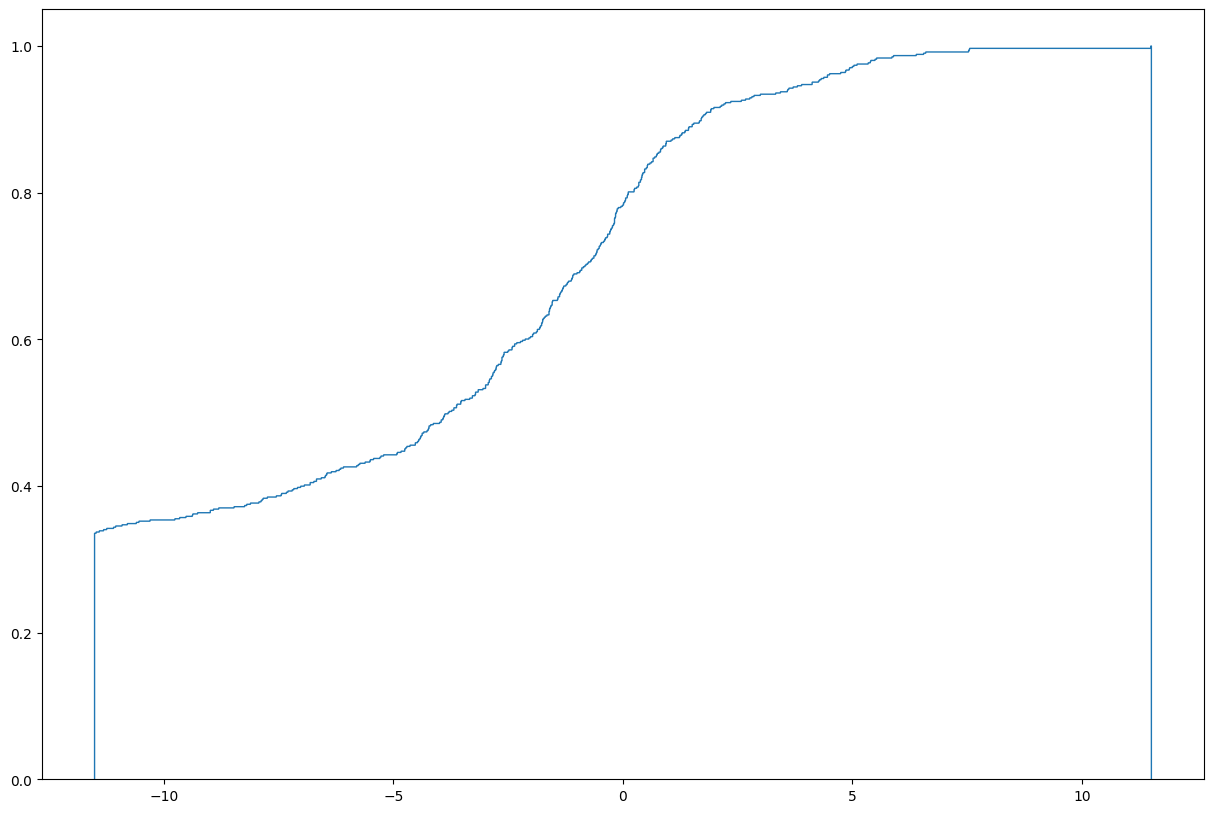

In [31]:
pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=250,
    numberofVars=1,
    numberofYs=1,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
).to(device)


print(train_dataset.itos)

model_path = "/content/drive/MyDrive/Colab Notebooks/STAT946_proj/models/best_model_119.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

test_results = run_and_plot(model, test_loader, textTest, train_dataset, device, pconfig)